# CHF - Statistics

This script is the follow-up of "rk_find_peaks4" for the CHF data.

author: *roman kessler* (kesslerr@med.uni-marburg.de)

date: *Sep 24, 2017* (election day)

What it does:
1. it reads the evoked responses from a text file
2. finding the maximum/minimum average values in each condition
3. doing a fourier transformation of the files to extract
    a. amplitude information (not yet corretly converted)
    b. phase shift
4. plots the results


In [1]:
%matplotlib inline
%pylab inline --no-import-all
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
import csv
import math
from pylab import *
import os 
import seaborn as sns
sns.axes_style('darkgrid')

Populating the interactive namespace from numpy and matplotlib


{'figure.facecolor': 'white',
 'axes.labelcolor': '.15',
 'xtick.direction': 'out',
 'ytick.direction': 'out',
 'xtick.color': '.15',
 'ytick.color': '.15',
 'axes.axisbelow': True,
 'grid.linestyle': '-',
 'text.color': '.15',
 'font.family': ['sans-serif'],
 'font.sans-serif': ['Arial',
  'DejaVu Sans',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'image.cmap': 'rocket',
 'xtick.top': False,
 'ytick.right': False,
 'axes.grid': True,
 'axes.facecolor': '#EAEAF2',
 'axes.edgecolor': 'white',
 'grid.color': 'white',
 'axes.spines.left': True,
 'axes.spines.bottom': True,
 'axes.spines.right': True,
 'axes.spines.top': True,
 'xtick.bottom': False,
 'ytick.left': False}

# single subject responses

In [3]:
pathFiles1 = 'evoked_'
pathCond   = ['cond_1','cond_2','cond_3','cond_4summation_','cond_4','cond_5','cond_6','cond_7summation_','cond_7','cond_8','cond_9','cond_10summation_','cond_10','cond_11','cond_12','cond_13summation_']
pathFiles2 = '_eoi_Pz_ref_[TP9, TP10].txt'
pathExp    = 'E:/CHF/processing_new_all/' #'/media/cth/Samsung_T3/CHF/processing_new/'

evoked_data = []
dataMin  = [];     dataMax  = [];      dataAbs   = []

for subjectno, ind in zip( range(4,11) , range(7) ): # load subjects # 4 to subject # 10
    if subjectno < 10:
        subjectstr = 'RK_2000' + str(subjectno)
    else:
        subjectstr = 'RK_200'  + str(subjectno)


    pathBase   = 'E:/CHF/processing_new_all/' + subjectstr + '/data/'

    dataMinSub  = [];     dataMaxSub  = [];      dataAbsSub   = []
    evoked_dataSub = []
    
    for icond in pathCond:
        
        #print(subjectstr + ' ' + icond)
        data      = np.loadtxt(pathBase + pathFiles1 + icond + pathFiles2)                 # load ERPs
        dataMinSub.append(np.amin(data[322:-1]))                                                   # find maximum value
        dataMaxSub.append(np.amax(data[322:-1]))                                                   # find minimum value
        dataAbsSub.append(np.amax([abs(dataMaxSub[-1]),abs(dataMinSub[-1])]))                      # absolute value
        evoked_dataSub.append(data)
    
    evoked_data.append(evoked_dataSub)
    dataMin.append(dataMinSub)
    dataMax.append(dataMaxSub)
    dataAbs.append(dataAbsSub)

OSError: E:/CHF/processing_new_all/RK_20004/data/evoked_cond_1_eoi_Pz_ref_[TP9, TP10].txt not found.

# phase of the signal

## fourier transformation

In [17]:
periodDur            = [546,279,145,78]
Nstim                = [4,8,15,30]
stimFreq             = [2,4,8,15]
visualFields         = ['FVF','LVF','UVF','SUM']
periodDur            = [periodDur[i//4] for i in range(16)]
Nstim                = [Nstim[i//4] for i in range(16)]

def fourier(coi, evoked_data, plot, save):
    y = evoked_data[coi]                                        # change here to get a full period length 
    y = y[ 322 : 322 + Nstim[coi] * periodDur[coi] ]            # eliminate leakage effect, ensure periodicity of the signal

    Fs = len(y);                                                # sampling rate
    Ts = 1;                                                     # sampling interval
    t = np.arange(0,Fs,1)                                       # time vector

    n = len(y)                                                  # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/2 #T                                                # two sides frequency range
    frq = frq[range(int(n/2))]                                  # one side frequency range

    Y = np.fft.fft(y)/n                                         # fft computing and normalization
    Y = Y[range(int(n/2))]

    border=40
    
    if plot == True:
        fig, ax = plt.subplots(2, 1)
        ax[0].plot(t,y)
        ax[0].set_xlabel('Time')
        ax[0].set_ylabel('Amplitude')
        ax[1].plot(frq,abs(Y),'r')                              # plotting the spectrum
        xlim(0,border)
        ax[1].set_xlabel('Freq (Hz)')
        ax[1].set_ylabel('|Y(freq)|')
    
    if save == True:
        plt.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'fourier_1000dpi_' + str(stimFreq[int(coi/4)]) + visualFields[int(coi%4)], dpi=1000)
        plt.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'fourier_50dpi_'   + str(stimFreq[int(coi/4)]) + visualFields[int(coi%4)], dpi=50)
    
    angle = np.angle(Y)
    angledeg = [math.degrees(i) for i in angle]; #angledeg

    idx, = np.where( abs(Y) == amax(abs(Y)) )
    #print('index of greatest value: ' + str(idx[0]) )
    frequency = frq[idx[0]]
    #print('frequency with greatest power: ' + str(frequency) )
    shiftDeg = angledeg[idx[0]]
    #print('angle of greatest value: ' + str(shift))
    shiftRad = angle[idx[0]]
    
    # calculate the amplitude and power at the given frequency
    amplitude = abs(Y[idx[0]])
    power     = abs(Y[idx[0]])**2
    
    return shiftDeg, shiftRad, frequency, y, amplitude, power

In [18]:
shiftDeg               = []
shiftRad               = []
frequency              = []
evoked_data_sparse     = []                            # the full-period data, without start and end-time
amplitudes             = []
powers                 = []

plot = False                                           # plot the results?
save = False                                           # save the figures?

for isub in range(0,7):
    
    shiftDegSub               = []
    shiftRadSub               = []
    frequencySub              = []
    evoked_data_sparseSub     = []
    amplitudeSub              = []
    powerSub                  = []
    
    for i in range(len(evoked_data[isub])):                      # loop through conditions
        a, b, c, y, am, po = fourier(i, evoked_data[isub], plot, save)
        shiftDegSub.append(a)
        shiftRadSub.append(b)
        frequencySub.append(c)
        evoked_data_sparseSub.append(y)
        amplitudeSub.append(am)
        powerSub.append(po)
    
    shiftDeg.append(shiftDegSub)
    shiftRad.append(shiftRadSub)
    frequency.append(frequencySub)
    evoked_data_sparse.append(evoked_data_sparseSub)
    amplitudes.append(amplitudeSub)
    powers.append(powerSub)

    

### normalizing angles
Use the first of 4 values (full visual field stimulation) as 0 degree shift. Proceed with the other angles in relation to this value.

In [19]:
shiftRadNorm = []                      # write normalized angles (norm. to FVF stimulation) in a new list
shiftDegNorm = []
for isub in range(7):
    shiftRadTmp = shiftRad[isub]
    shiftDegTmp = shiftDeg[isub]
    
    shiftRadNormSub = []
    shiftDegNormSub = []
    
    for icond in range(16):                # 16 conditions
        shiftRadNormSub.append(shiftRadTmp[icond] - shiftRadTmp[int(floor(icond/4)*4)])
        shiftDegNormSub.append(shiftDegTmp[icond] - shiftDegTmp[int(floor(icond/4)*4)])
#        print(shiftRad[int(floor(icond/4)*4)])
    
    shiftRadNorm.append(shiftRadNormSub)
    shiftDegNorm.append(shiftDegNormSub)
    

### converting angles to millisecons delay

lag in ms = radial shift  x  length of full cycle in ms / ( 2 * pi )

In [20]:
shiftTimeNorm = []                                                 # write ms delay in a new list
for isub in range(7):
    shiftRadNormSub = shiftRadNorm[isub]
    shiftTimeNormSub = []
    for icond in range(16):                                            # 16 conditions
        timeCycle = periodDur[icond]
        # calculate time shift
        timeShift = timeCycle * shiftRadNormSub[icond] / ( 2 * np.pi )    # formula to calculate times
        shiftTimeNormSub.append(timeShift)
    shiftTimeNorm.append(shiftTimeNormSub)

This is the average delay (in mm) of the respective Hz response, normalized to the FVF response (which is set to 0 mm)

In [21]:
shiftTimeNorm

[[0.0,
  -33.020618983789873,
  -291.24410821851734,
  3.8091178189751647,
  0.0,
  -15.9904909367899,
  -224.09868122929052,
  2.1197260680275507,
  0.0,
  -44.039898537829885,
  8.705208435569471,
  -62.362135548865226,
  0.0,
  3.6577292110383222,
  -2.1179675886306644,
  0.15000815418843175],
 [0.0,
  131.10146242887615,
  409.47882768820176,
  362.31526021187983,
  0.0,
  -47.264271987658233,
  26.062770936074031,
  -6.1838674978767658,
  0.0,
  13.749076239935411,
  47.270331159314765,
  -0.89642133160005077,
  0.0,
  20.729328917707587,
  -9.1201641061165244,
  -2.7801359867451607],
 [0.0,
  17.698819824775299,
  -216.77622554413398,
  12.053707876303395,
  0.0,
  11.542762341171139,
  -2.8142691123362247,
  7.133866166383676,
  0.0,
  -7.3534270398213764,
  13.540740549098912,
  0.88466638176436951,
  0.0,
  3.35171056294902,
  2.6367606583605676,
  0.4622337061464275],
 [0.0,
  -9.1380635652152602,
  -372.91933036754153,
  -371.83414449402926,
  0.0,
  -5.5221362750117882,
  -

This is the average delay in degree. Normalized to FVF response (which is set to 0 degree). Note, that the angle is with respect to the frequency, thus a particular angle in the 2 Hz conditions means a higher time difference than in the 4 Hz condition (and so on).

In [22]:
shiftTimeNorm

[[0.0,
  -33.020618983789873,
  -291.24410821851734,
  3.8091178189751647,
  0.0,
  -15.9904909367899,
  -224.09868122929052,
  2.1197260680275507,
  0.0,
  -44.039898537829885,
  8.705208435569471,
  -62.362135548865226,
  0.0,
  3.6577292110383222,
  -2.1179675886306644,
  0.15000815418843175],
 [0.0,
  131.10146242887615,
  409.47882768820176,
  362.31526021187983,
  0.0,
  -47.264271987658233,
  26.062770936074031,
  -6.1838674978767658,
  0.0,
  13.749076239935411,
  47.270331159314765,
  -0.89642133160005077,
  0.0,
  20.729328917707587,
  -9.1201641061165244,
  -2.7801359867451607],
 [0.0,
  17.698819824775299,
  -216.77622554413398,
  12.053707876303395,
  0.0,
  11.542762341171139,
  -2.8142691123362247,
  7.133866166383676,
  0.0,
  -7.3534270398213764,
  13.540740549098912,
  0.88466638176436951,
  0.0,
  3.35171056294902,
  2.6367606583605676,
  0.4622337061464275],
 [0.0,
  -9.1380635652152602,
  -372.91933036754153,
  -371.83414449402926,
  0.0,
  -5.5221362750117882,
  -

### polar plot of responses
example fot this polar bar plot: https://matplotlib.org/examples/pie_and_polar_charts/polar_bar_demo.html
or a polar scatter plot: https://matplotlib.org/examples/pie_and_polar_charts/polar_scatter_demo.html

#### peak response vs. frequency shift

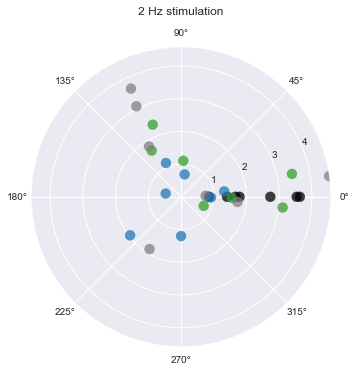

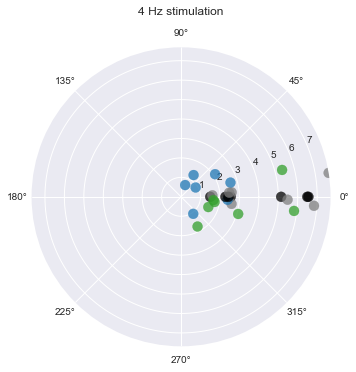

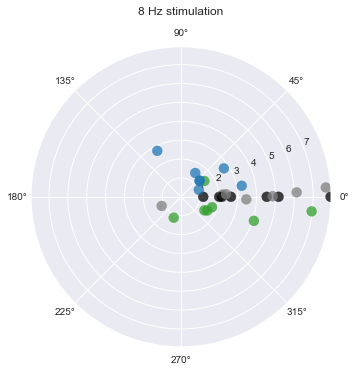

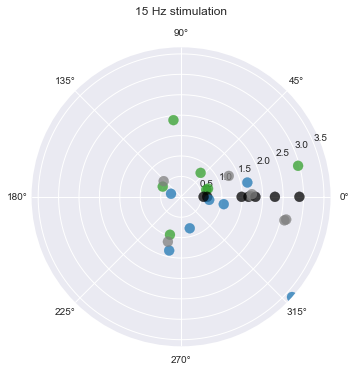

In [31]:
for i in range(4):
    N = 4                                        # N of conditions per frequency: here: FVF, UVF, LVF, SUM    
    theta = []
    r = []
    for isub in range(7):
        for j in range(4):
            theta.append( shiftRadNorm[isub][i*4+j] )        # position on the circle (like position on the x-axis)
            #r.append( 1000000 * dataAbs[isub][i*4+j] )       # position on radial axis (y-axis)
            r.append( 1000000 * amplitudes[isub][i*4+j] )       # position on radial axis (y-axis)
    
    ### VORSICHT: IM FOLGENDEN HABE ICH DATAABS statt DATAABS*Z* VERWENDET !!!! ANDERE INTERPRETATION DER AMPLITUDE!!!
    #print( str( size(theta) ) + ' thetas: ' )
    #print(theta)

    # Compute areas and colors
    #N = 150
    #r = 2 * np.random.rand(len(theta))
    #print(r)
    area = 100 #* r**2
    #colors = theta
    colors = [(0,0,0),(51/255,160/255,44/255),(31/255,120/255,180/255),(0.5,0.5,0.5)]    # here black, green, blue, gray
    colors = colors + colors + colors + colors + colors + colors + colors
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='polar')
    ax.set_ylim(0,max(r))
    ax.set_title(str(stimFreq[i]) + ' Hz stimulation\n')
    
    ax.scatter(theta, r, marker='o', c=colors, s=area, cmap='hsv', alpha=0.75)
    #c = ax.scatter(theta, r, marker='o', c=colors, s=area, cmap='hsv', alpha=0.75)
    #ax.legend(c, visualFields, loc='center left')
    
    # save figures
    fig.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'polar_individual_1000dpi_' + str(stimFreq[i]), dpi=1000)
    fig.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'polar_individual_50dpi_' + str(stimFreq[i]), dpi=50)
    

In [28]:
visualFields

['FVF', 'UVF', 'LVF', 'SUM']

#### frequency shift per subject (without avg. response)

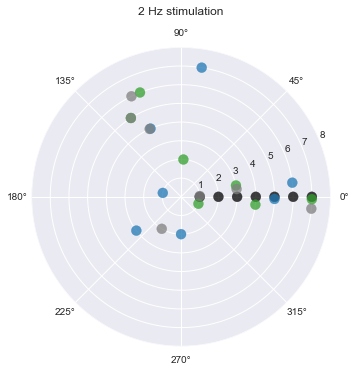

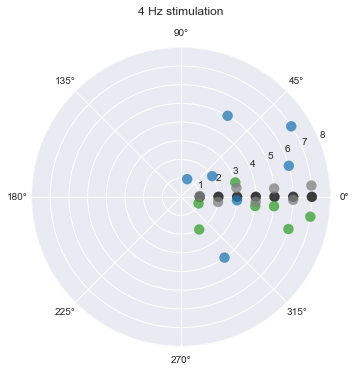

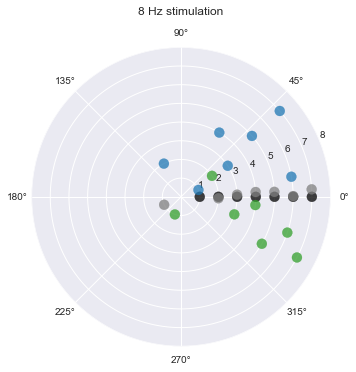

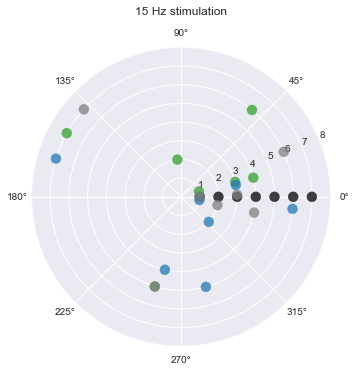

In [34]:
for i in range(4):
    N = 4                                        # N of conditions per frequency: here: FVF, UVF, LVF, SUM    
    theta = []
    r = []
    time = []
    for isub in range(7):
        for j in range(4):
            theta.append( shiftRadNorm[isub][i*4+j] )        # position on the circle (like position on the x-axis)
            r.append( isub + 1 )       # position on radial axis (y-axis)
            time.append( shiftTimeNorm[isub][i*4+j] )
    
    # save special array for 8Hz and 15 Hz condition
    if i == 2: # 8 Hz condition
        theta8 = theta
        time8  = time
    elif i == 3: # 16 Hz condition
        theta16 = theta
        time16  = time
    #print( str( size(theta) ) + ' thetas: ' )
    #print(theta)

    # Compute areas and colors
    #N = 150
    #r = 2 * np.random.rand(len(theta))
    #print(r)
    area = 100 #* r**2
    #colors = theta
    colors = [(0,0,0),(51/255,160/255,44/255),(31/255,120/255,180/255),(0.5,0.5,0.5)]    # here black, green, blue, gray
    colors = colors + colors + colors + colors + colors + colors + colors
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='polar')
    ax.set_ylim(0,max(r)+1)
    ax.set_title(str(stimFreq[i]) + ' Hz stimulation\n')
    
    c = ax.scatter(theta, r, marker='o', c=colors, s=area, cmap='hsv', alpha=0.75)
    #ax.legend(c, visualFields, loc='best')
    
    # save figures
    #fig.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'polar_individual_sub_1000dpi_' + str(stimFreq[i]), dpi=1000)
    #fig.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'polar_individual_sub_50dpi_' + str(stimFreq[i]), dpi=50)
    

In [35]:
len(evoked_data_sparse)


7

In [36]:
theta8

[0.0,
 -1.9083506442936031,
 0.37721681198831652,
 -2.7022955434825637,
 0.0,
 0.5957792677107181,
 2.0483327600394476,
 -0.038844009239667576,
 0.0,
 -0.31864099816567415,
 0.58675160045813191,
 0.038334640080397331,
 0.0,
 -0.11071824955965071,
 1.0338110222419554,
 0.064366368166544286,
 0.0,
 -0.52663405098451532,
 0.70974306767352802,
 0.053174977081010932,
 0.0,
 -0.32475373554097431,
 0.17999848888576775,
 0.0066988490994046579,
 0.0,
 -0.4823717767079736,
 0.71579901096344989,
 0.057348799345221968]

In [37]:
shiftRadNorm[:][0::6]

[[0.0,
  -0.37999023449253455,
  -3.3515397464491015,
  0.043834053321429867,
  0.0,
  -0.36011189142876932,
  -5.0467868862301071,
  0.04773703113217298,
  0.0,
  -1.9083506442936031,
  0.37721681198831652,
  -2.7022955434825637,
  0.0,
  0.29464346713381495,
  -0.17061003633290728,
  0.01208370551735749],
 [0.0,
  -0.018524361807616962,
  1.412387898473364,
  -0.091117848232583398,
  0.0,
  -0.15290253437809342,
  0.56930311998118954,
  0.085982609001266752,
  0.0,
  -0.4823717767079736,
  0.71579901096344989,
  0.057348799345221968,
  0.0,
  -3.6496611369375502,
  -3.4377534478099423,
  -3.8745739623541118]]

#### frequency shift per subject (without avg. response) - unfolding the polar diagram into a bar plot

In [38]:
import seaborn as sns
import pandas as pd 

for the 8 Hz condition

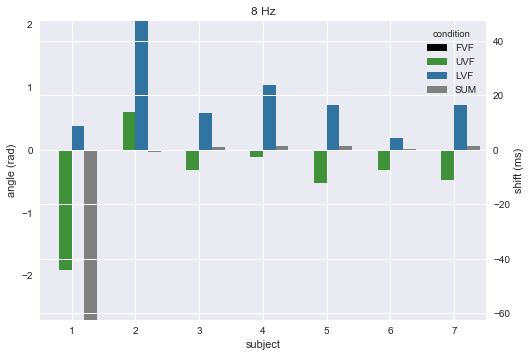

In [44]:
d = {'angle':         theta8,
     'condition':     ['FVF','UVF','LVF','SUM'] * 7,      # repeat the conditions for 7 subjects
     'subject':       [val for val in [1,2,3,4,5,6,7] for _ in (0,1,2,3)]  # doublicate (here quadrubble it) each member in a list
    }
df = pd.DataFrame(data=d)
#df
#sns.set_style("white")
fig = plt.figure()

sns.axes_style("darkgrid")

ax = sns.barplot(x="subject", y="angle", hue="condition", data=df,
                #color=colors
                palette = [(0,0,0),(51/255,160/255,44/255),(31/255,120/255,180/255),(0.5,0.5,0.5)]
                )
ax.set(ylabel='angle (rad)')

# create a second y-axis, to display also the millisecond shift instead of degree shift
ax2 = ax.twinx() # this effectively uses the x axis of the first plot for this second one
ax.grid()        # create a grid on basis of the first axis
ax2.set_ylabel("shift (ms)")
#ax2.set_ylim(0, 35) ## TO DO
ax.set_title('8 Hz')

# set common y axis range
ax.set_ylim(bottom=np.min(theta8), top=np.max(theta8))
ax2.set_ylim(bottom=np.min(time8), top=np.max(time8))
#ax.set_ylim(bottom=np.min(theta8+theta16), top=np.max(theta8+theta16))
#ax2.set_ylim(bottom=np.min(time8+time16), top=np.max(time8+time16))

#ax2.grid()

   
fig.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'barplot_shift_8Hz_individual_sub_1000dpi_' + str(stimFreq[i]), dpi=1000)
fig.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'barplot_shift_8Hz_individual_sub_50dpi_' + str(stimFreq[i]), dpi=50)
    

In [40]:
np.min([1,2,3]+[3,4,5])

1

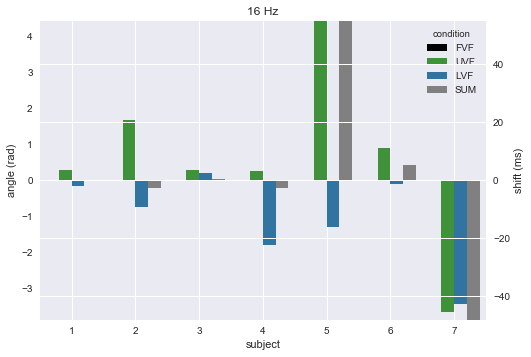

In [45]:
d = {'angle':         theta16,
     'condition':     ['FVF','UVF','LVF','SUM'] * 7,      # repeat the conditions for 7 subjects
     'subject':       [val for val in [1,2,3,4,5,6,7] for _ in (0,1,2,3)]  # doublicate (here quadrubble it) each member in a list
    }
df = pd.DataFrame(data=d)

fig = plt.figure()
sns.axes_style("darkgrid")

ax = sns.barplot(x="subject", y="angle", hue="condition", data=df,
                #color=colors
                palette = [(0,0,0),(51/255,160/255,44/255),(31/255,120/255,180/255),(0.5,0.5,0.5)]
                )
ax.set(ylabel='angle (rad)')

# create a second y-axis, to display also the millisecond shift instead of degree shift
ax2 = ax.twinx() # this effectively uses the x axis of the first plot for this second one
ax.grid()
ax2.set_ylabel("shift (ms)")
#ax2.set_ylim(0, 35) ## TO DO
ax.set_title('16 Hz')

# mutual y range
ax.set_ylim(bottom=np.min(theta16), top=np.max(theta16))
ax2.set_ylim(bottom=np.min(time16), top=np.max(time16))
#ax.set_ylim(bottom=np.min(theta8+theta16), top=np.max(theta8+theta16))
#ax2.set_ylim(bottom=np.min(time8+time16), top=np.max(time8+time16))

fig.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'barplot_shift_16Hz_individual_sub_1000dpi_' + str(stimFreq[i]), dpi=1000)
fig.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'barplot_shift_16Hz_individual_sub_50dpi_' + str(stimFreq[i]), dpi=50)
    

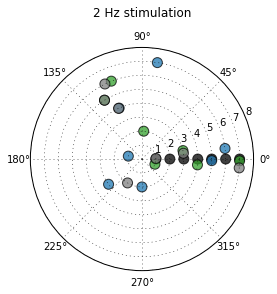

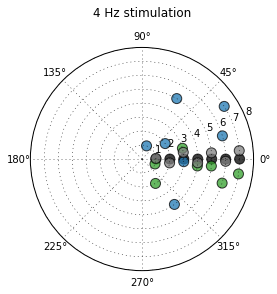

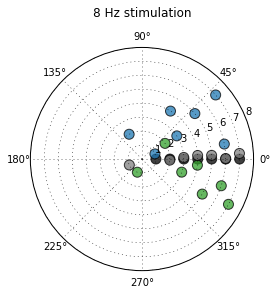

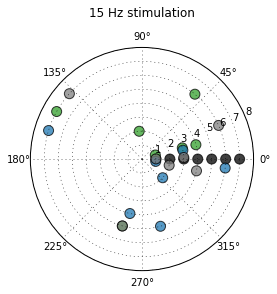

In [14]:
for i in range(4):
    N = 4                                        # N of conditions per frequency: here: FVF, UVF, LVF, SUM    
    theta = []
    r = []
    for isub in range(7):
        for j in range(4):
            theta.append( shiftRadNorm[isub][i*4+j] )        # position on the circle (like position on the x-axis)
            r.append( isub + 1 )       # position on radial axis (y-axis)
    
    #print( str( size(theta) ) + ' thetas: ' )
    #print(theta)

    # Compute areas and colors
    #N = 150
    #r = 2 * np.random.rand(len(theta))
    #print(r)
    area = 100 #* r**2
    #colors = theta
    colors = [(0,0,0),(51/255,160/255,44/255),(31/255,120/255,180/255),(0.5,0.5,0.5)]    # here black, green, blue, gray
    colors = colors + colors + colors + colors + colors + colors + colors
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='polar')
    ax.set_ylim(0,max(r)+1)
    ax.set_title(str(stimFreq[i]) + ' Hz stimulation\n')
    
    c = ax.scatter(theta, r, marker='o', c=colors, s=area, cmap='hsv', alpha=0.75)
    #ax.legend(c, visualFields, loc='best')
    
    # save figures
    fig.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'polar_individual_sub_1000dpi_' + str(stimFreq[i]), dpi=1000)
    fig.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'polar_individual_sub_50dpi_' + str(stimFreq[i]), dpi=50)
    

## cross-correlation as a measure of phase

to do ? or is a FFT sufficient ?


# similarity between curves

## sum of squares (here: mean squared error)
For each x value, compute delta_yi = y1,i - y2,i and accumulate delta_yi2. This metric is the basis for a least square optimization, where the goal is to minimize the sum of the squares of the errors. This is a widely used approach because oftentimes it is fairly easy to implement.
https://stackoverflow.com/questions/6723157/how-to-compare-two-curves-arrays-of-points

MSE = 1 / n * sum ( ( Y(pred) - Y(obs) ) ^ 2 )

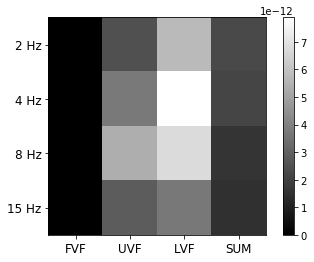

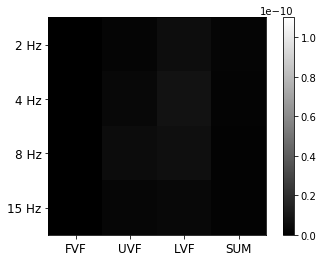

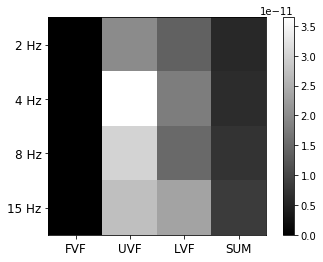

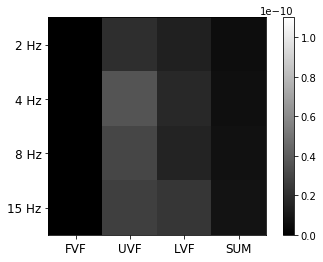

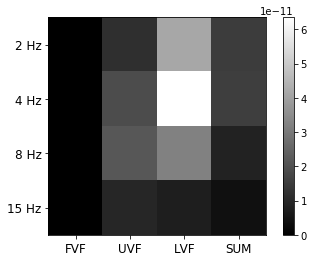

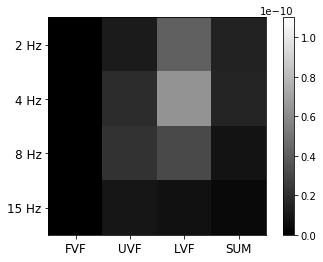

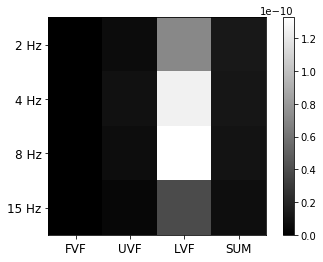

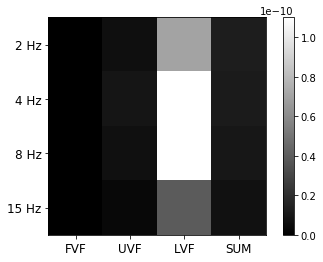

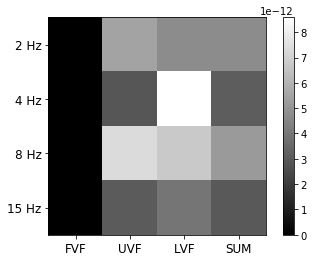

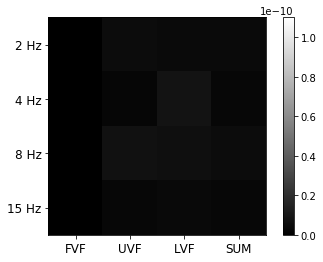

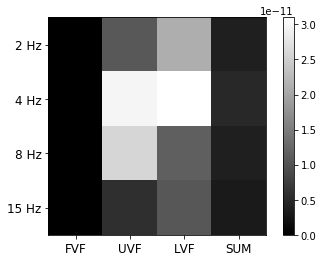

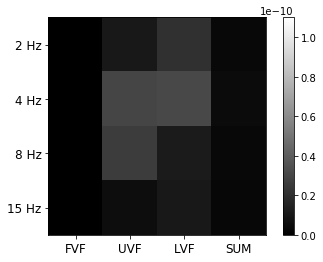

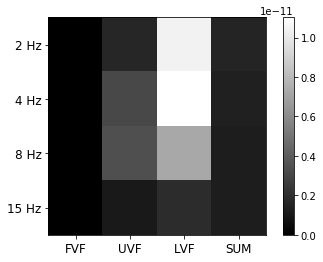

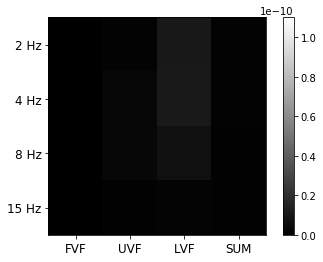

In [10]:
colorBarMax = 1.1e-10 # i think this was the maximum value in all data
MSEall = []

for isub in range(7):
    Ncond = len(evoked_data_sparse[0])                              # total # conditions
    MSE = zeros((4,4))                                # empty array to store all comparisons
    for i1, i1i in zip( [0,4,8,12] , range(4) ):           # go in 1st dimension
        for i2, i2i in zip( range(i1,i1+4), range(4) ):  # go in 2nd dimension
            SE = []
            Ntp   = len(evoked_data_sparse[isub][i1])                  # total # time points
        
            for j in range(Ntp):                                 # go through the data
                Yp = evoked_data_sparse[isub][i1][j]
                Yo = evoked_data_sparse[isub][i2][j]
                SE.append( ( ( Yp - Yo ) ** 2 ) )
            
            MSE[i1i][i2i] = 1 / Ntp * sum(SE)

    # use the following line to create a individual colorbar for each subject, suitable for intra-subject
    # comparison, but not so good for inter-subject comparisons
    fig = plt.imshow(MSE, cmap='gray', interpolation='nearest')  # plot
    
    plt.colorbar()
    xlabels = ['FVF','UVF','LVF','SUM']
    ylabels = ['2 Hz','4 Hz','8 Hz','15 Hz']
    plt.xticks(range(len(xlabels)), xlabels, fontsize=12)
    plt.yticks(range(len(ylabels)), ylabels, fontsize=12)
    
    # save plots
    plt.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'MSE_sub' + str(isub+1) + '_50dpi',   dpi=50)
    plt.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'MSE_sub' + str(isub+1) + '_1000dpi', dpi=1000)
    plt.show()

    MSEall.append(MSE)
    
    # use the following line to create a shared, common colorbar range for all subjects -
    # better for inter-subject comparisons
    fig = plt.imshow(MSE, vmin=0, vmax=colorBarMax, cmap='gray', interpolation='nearest')  # this uses a specific colorbarrange (useful, if all subjects shall be displayed in a similar range)
    plt.colorbar()
    xlabels = ['FVF','UVF','LVF','SUM']
    ylabels = ['2 Hz','4 Hz','8 Hz','15 Hz']
    plt.xticks(range(len(xlabels)), xlabels, fontsize=12)
    plt.yticks(range(len(ylabels)), ylabels, fontsize=12)    

    # save plots
    plt.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'MSEsharedcolorbar_sub' + str(isub+1) + '_50dpi',   dpi=50)
    plt.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'MSEsharedcolorbar_sub' + str(isub+1) + '_1000dpi', dpi=1000)
    plt.show()
    
    
    #print(MSE)

# only for the SUM condition compared to FVF
#sumMSE = MSE[:][-1] # In your specific case you got a 1D array, so you need to add a dimension with np.expand_dims()
#sumMSE = np.asarray(sumMSE)
#sumMSE = np.expand_dims(sumMSE, axis=0)
#sumMSE = np.transpose(sumMSE)
#
#fig = plt.imshow(sumMSE, cmap='gray', interpolation='nearest')  # plot
#plt.colorbar()
#xlabels = ['SUM']
#ylabels = ['2 Hz','4 Hz','8 Hz','15 Hz']
#plt.xticks(range(len(xlabels)), xlabels, fontsize=12)
#plt.yticks(range(len(ylabels)), ylabels, fontsize=12)
#plt.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'MSEsum_50dpi',   dpi=50)
#plt.savefig(pathExp + 'group' + os.sep + 'plots' + os.sep + 'MSEsum_1000dpi', dpi=1000)
#plt.show()

1.1e-10

### compare the similarities bt curves


In [32]:
MSEall[0][1][2]

2.1371791482690699e-12

In [41]:
from scipy import *
from scipy import stats

# define the two variables
xUVF2  = [];    xLVF2  = []
xUVF4  = [];    xLVF4  = []
xUVF8  = [];    xLVF8  = []
xUVF15 = [];    xLVF15 = []

for isub in range(7):
    xUVF2.append(MSEall[isub][0][1])
    xLVF2.append(MSEall[isub][0][2])
    xUVF4.append(MSEall[isub][1][1])
    xLVF4.append(MSEall[isub][1][2])
    xUVF8.append(MSEall[isub][2][1])
    xLVF8.append(MSEall[isub][2][2])
    xUVF15.append(MSEall[isub][3][1])
    xLVF15.append(MSEall[isub][3][2])

#scipy.stats.
print(scipy.stats.wilcoxon(x=xUVF2, y=xLVF2, zero_method='wilcox', correction=False))
print(scipy.stats.wilcoxon(x=xUVF4, y=xLVF4, zero_method='wilcox', correction=False))
print(scipy.stats.wilcoxon(x=xUVF8, y=xLVF8, zero_method='wilcox', correction=False))
print(scipy.stats.wilcoxon(x=xUVF15, y=xLVF15, zero_method='wilcox', correction=False))

WilcoxonResult(statistic=4.0, pvalue=0.090968947975357747)
WilcoxonResult(statistic=5.0, pvalue=0.12819017434510785)
WilcoxonResult(statistic=12.0, pvalue=0.73531669063734051)
WilcoxonResult(statistic=9.0, pvalue=0.39802471950693785)


## maximum deviation
Find the abs_delta_yi = |y1,i - y2,i| that maximizes the |y1,i - y2,i| for all x values. This metric is the basis for a lot of the implementations of the functions in the math library, where the goal is to minimize the maximum error. These math library implementations are approximations of the true function. As a consumer of such an approximation, I typically care more about the worst thing that the approximation is going to do to my application than I care about how that approximation is going to behave on average. https://stackoverflow.com/questions/6723157/how-to-compare-two-curves-arrays-of-points

## weighted least squares
'In my research I compared two curves (data vs model) and I used the  weighted least squares (WLS)
For the WLS method it was defined as the sum of the absolute differences between observed and expected values, divided by the observed values (Lika et al. 2011).'
https://www.researchgate.net/post/Is_there_any_statistical_method_to_compare_two_curves_in_a_graph_eg_quantifying_how_similar_different_they_are

WLS = 1 / n * sum ( | 1 - ( expected value / observed value) | )

Ncond = len(evoked_data)                                     # total # conditions
Ntp   = len(evoked_data[0])                                  # total # time points
WLS2 = zeros( (Ncond, Ncond) )                             # empty array to store all comparisons
for i1 in range(Ncond):                                      # go in 1st dimension
    for i2 in range(Ncond):                                  # go in 2nd dimension
        LS=[]
        for j in range(Ntp):                                 # go through the data
            ev = evoked_data[i1][j]
            ov = evoked_data[i2][j]
            LS.append( abs( ( 1 - ev / ov ) ) )
        WLS2[i1][i2] = 1 / Ntp * sum(LS)
fig = plt.imshow(WLS2, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()